Title: Siamese network with a contrastive loss   
Author: Mehdi   
Date created: 2021/05/06   
Last modified: 2021/05/06   
Description: Similarity learning using siamese network with contrastive loss   

## Introduction

[Siamese Network](https://en.wikipedia.org/wiki/Siamese_neural_network)
is any Neural Network which share weights between two or more sister networks,
each producing embedding vector of its respective input and these embeddings
are then passed through some 
[distance heuristic](https://developers.google.com/machine-learning/clustering/similarity/measuring-similarity)
to find the distance between them. This distance is later used to increase the
contrast between embeddings of inputs of different classes and decrease it with
that of similar class by employing some loss function, with the main objective
of contrasting [vector spaces](https://en.wikipedia.org/wiki/Vector_space)
from which these sample inputs were taken.

## Setup

In [1]:
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve,auc

Define some hyperparameters

In [2]:
epochs = 10
batch_size = 16
# margin for constrastive loss
margin = 1

## Load the MNIST dataset

In [3]:
(x_train_val, y_train_val), (x_test, y_test) = keras.datasets.mnist.load_data()

# Change the data type to a floating point format
x_train_val = x_train_val.astype("float32")
x_test = x_test.astype("float32")

11493376/11490434 [==============================] - 0s 0us/step


Use list slicing to split train_val data into `train` and `val`

In [4]:
# Keep 50% of train_val  in validation set 
x_train, x_val = x_train_val[0:30000], x_train_val[30000:]
y_train, y_val = y_train_val[0:30000], y_train_val[30000:] 
del x_train_val
del y_train_val

## Create pairs of images

We will train the model to differentiate each digit from one another. For
example, digit `0` needs to be differentiated from the rest of the
digits (`1` through `9`), digit `1` - from `0` and `2` through `9`, and so on.
To carry this out, we will select N random images from class A (for example,
for digit `0`) and pair it with N random images from another class B
(for example, for digit `1`). Then, we can repeat this process for all classes
of digits (until digit `9`). Once we have paired digit `0` with other digits,
we can repeat this process for the remaining classes for the rest of the digits
(from `1` until `9`).

In [5]:
def make_pairs(x, y):
    """Creates a tuple containing image pairs with corresponding label.

    Arguments:
        x: List containing images, each index in this list corresponds to
            one image.
        y: List containing labels, each label with datatype of `int`.

    Returns:
        Tuple containing two numpy arrays as (pairs_of_samples, labels),
        where pairs_of_samples' shape is (2len(x), 2,n_features_dims) and
        labels are a binary array of shape (2len(x)).
    """

    num_classes = max(y) + 1
    digit_indices = [np.where(y == i)[0] for i in range(num_classes)]

    pairs = []
    labels = []

    for idx1 in range(len(x)):
        # add a matching example
        x1 = x[idx1]
        label1 = y[idx1]
        idx2 = random.choice(digit_indices[label1])
        x2 = x[idx2]

        pairs += [[x1, x2]]
        labels += [1]

        # add a non-matching example
        label2 = random.randint(0, num_classes - 1)
        while label2 == label1:
            label2 = random.randint(0, num_classes - 1)

        idx2 = random.choice(digit_indices[label2])
        x2 = x[idx2]

        pairs += [[x1, x2]]
        labels += [0]

    return np.array(pairs), np.array(labels).astype("float32")

In [6]:
# make train pairs
pairs_train, labels_train = make_pairs(x_train, y_train)

# make validation pairs
pairs_val, labels_val = make_pairs(x_val, y_val)

# make test pairs
pairs_test, labels_test = make_pairs(x_test, y_test)

**pairs_train.shape = (60000, 2, 28, 28)**

Imagine it as:

**pairs_train.shape = (60000, pair.shape)**


`pairs_train` contains 60K `pairs` in `axis 0`, shape of each pair
is (2,28,28) hence `each pair` of `pairs_train` contains one image in its
`axis 0` (do not confuse it with the `axis 0` of `pairs_train`) and the
other one in the `axis 1`. We will slice `pairs_train` on its `axix 0`
followed by desired axis of pair to obtain all images (60K) which belong
either to the `axis 0` or the `axis 1` of all the pairs of `pairs_train`.


**Note:** Do not confuse axes of `pairs_train` with those of
`pair within pairs_train`, `pairs_train` have only one axis `axis 0` which
contain 60K pairs, whereas each `pair within pairs_train` have two axis,
each for one image of a pair.

Separate train pairs

In [7]:
x_train_1 = pairs_train[:, 0]
x_train_2 = pairs_train[:, 1]
# x_train_1.shape = (60000, 28, 28)

Separate validation pairs

In [8]:
x_val_1 = pairs_val[:, 0]
x_val_2 = pairs_val[:, 1]
# x_val_1.shape = (60000, 28, 28)

Separate test pairs

In [9]:
x_test_1 = pairs_test[:, 0]
x_test_2 = pairs_test[:, 1]
# x_test_1.shape = (20000, 28, 28)

## Visualize

In [10]:
def visualize(pairs, labels, to_show=6, num_col=3, predictions=None, test=False):
    """Creates a plot of pairs and labels, and prediction if it's test dataset.

    Arguments:
        pairs: Numpy Array, of pairs to visualize, having shape
              (Number of pairs, 2, 28, 28).
        to_show: Int, number of examples to visualize (default is 6)
                `to_show` must be an integral multiple of `num_col`.
                Otherwise it will be trimmed if it is greater than num_col,
                and incremented if if it is less then num_col.
        num_col: Int, number of images in one row - (default is 3)
                For test and train respectively, it should not exceed 3 and 7.
        predictions: Numpy Array of predictions with shape (to_show, 1) -
                (default is None)
                Must be passed when test=True.
        test: Boolean telling whether the dataset being visualized is 
                train dataset or test dataset - (default False).

    Returns:
        None.
    """

    # Define num_row
    # If to_show % num_col != 0
    #    trim to_show,
    #       to trim to_show limit num_row to the point where
    #       to_show % num_col == 0
    #
    # If to_show//num_col == 0
    #    then it means num_col is greater then to_show
    #    increment to_show
    #       to increment to_show set num_row to 1
    num_row = to_show // num_col if to_show // num_col != 0 else 1

    # `to_show` must be an integral multiple of `num_col`
    #  we found num_row and we have num_col
    #  to increment or decrement to_show
    #  to make it integral multiple of `num_col`
    #  simply set it equal to num_row * num_col
    to_show = num_row * num_col

    # Plot the images
    fig, axes = plt.subplots(num_row, num_col, figsize=(5, 5))
    for i in range(to_show):

        # If the number of rows is 1, the axes array is one-dimensional
        if num_row == 1:
            ax = axes[i % num_col]
        else:
            ax = axes[i // num_col, i % num_col]

        ax.imshow(tf.concat([pairs[i][0], pairs[i][1]], axis=1), cmap="gray")
        ax.set_axis_off()
        if test:
            ax.set_title("True: {} | Pred: {:.5f}".format(labels[i], predictions[i][0]))
        else:
            ax.set_title("Label: {}".format(labels[i]))
    if test:
        plt.tight_layout(rect=(0, 0, 1.9, 1.9), w_pad=0.0)
    else:
        plt.tight_layout(rect=(0, 0, 1.5, 1.5))
    plt.show()

Inspect train pairs

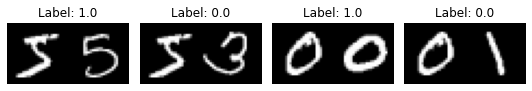

In [11]:
visualize(pairs_train[0:-1], labels_train[0:-1], to_show=4, num_col=4)

Inspect validation pairs

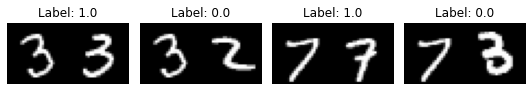

In [12]:
visualize(pairs_val[0:-1], labels_val[0:-1], to_show=4, num_col=4)

Inspect test pairs

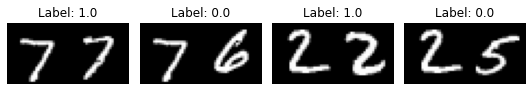

In [13]:
visualize(pairs_test[0:-1], labels_test[0:-1], to_show=4, num_col=4)

## Define the model

There will be two input layers, each leading to its own network, which
produces embeddings. Lambda layer will merge them using
[Euclidean distance](https://en.wikipedia.org/wiki/Euclidean_distance) and the
merged layer will be fed to final network.

In [14]:
# Provided two tensors t1 and t2
# Euclidean distance = sqrt(sum(square(t1-t2)))
def euclidean_distance(vects):
    """Find the Euclidean distance between two vectors.

    Arguments:
        vects: List containing two tensors of same length.

    Returns:
        Tensor containing euclidean distance
        (as floating point value) between vectors.
    """

    x, y = vects
    sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
    return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))

In [15]:
input = layers.Input((28, 28, 1))
x = tf.keras.layers.BatchNormalization()(input)
x = layers.Conv2D(4, (5, 5), activation="tanh")(x)
x = layers.AveragePooling2D(pool_size=(2, 2))(x)
x = layers.Conv2D(16, (5, 5), activation="tanh")(x)
x = layers.AveragePooling2D(pool_size=(2, 2))(x)
x = layers.Flatten()(x)

x = tf.keras.layers.BatchNormalization()(x)
x = layers.Dense(10, activation="tanh")(x)
embedding_network = keras.Model(input, x)


input_1 = layers.Input((28, 28, 1))
input_2 = layers.Input((28, 28, 1))

# As mentioned above, Siamese Network share weights between
# tower networks (sister networks). To allow this, we will use
# same embedding network for both tower networks.
tower_1 = embedding_network(input_1)
tower_2 = embedding_network(input_2)

merge_layer = layers.Lambda(euclidean_distance)([tower_1, tower_2])
normal_layer = tf.keras.layers.BatchNormalization()(merge_layer)
output_layer = layers.Dense(1, activation="sigmoid")(normal_layer)
siamese = keras.Model(inputs=[input_1, input_2], outputs=output_layer)

Define Constrastive Loss

In [16]:
def loss(margin=1):
  """Provides 'constrastive_loss' an enclosing scope with variable 'margin'.
  
  Arguments:
    margin: Integer, defines the baseline for distance for which pairs
            should be classified as dissimilar. - (default is 1).
  
  Returns:
    'constrastive_loss' function with data ('margin') attached.
  """

  # Contrastive loss = mean( (1-true_value) * square(prediction) +
  #                         true_value * square( max(margin-prediction, 0) ))
  def contrastive_loss(y_true, y_pred):
      """Calculate the constrastive loss.

      Arguments:
          y_true: List of labels, each label is of type float32.
          y_pred: List of predictions of same length as of y_true,
                  each label is of type float32.

      Returns:
          A tensor containing constrastive loss as floating point value.
      """

      square_pred = tf.math.square(y_pred)
      margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
      return tf.math.reduce_mean((1 - y_true) * square_pred + (y_true) * margin_square)
  return contrastive_loss

Compile the model with constrastive loss

In [17]:
siamese.compile(loss=loss(margin=margin), optimizer="RMSprop", metrics=["accuracy",keras.metrics.Precision(), keras.metrics.Recall(),keras.metrics.BinaryCrossentropy()])
siamese.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
model (Functional)              (None, 10)           5318        input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0           model[0][0]                

Train the model

In [18]:
history = siamese.fit(
    [x_train_1, x_train_2],
    labels_train,
    validation_data=([x_val_1, x_val_2], labels_val),
    batch_size=batch_size,
    epochs=epochs,
)

Epoch 1/10
3750/3750 [==============================] - 67s 9ms/step - loss: 0.1188 - accuracy: 0.8368 - precision: 0.8465 - recall: 0.8231 - binary_crossentropy: 0.3789 - val_loss: 0.0333 - val_accuracy: 0.9576 - val_precision: 0.9681 - val_recall: 0.9463 - val_binary_crossentropy: 0.1195
Epoch 2/10
3750/3750 [==============================] - 33s 9ms/step - loss: 0.0504 - accuracy: 0.9337 - precision: 0.9404 - recall: 0.9253 - binary_crossentropy: 0.1773 - val_loss: 0.0284 - val_accuracy: 0.9625 - val_precision: 0.9765 - val_recall: 0.9477 - val_binary_crossentropy: 0.1016
Epoch 3/10
3750/3750 [==============================] - 33s 9ms/step - loss: 0.0408 - accuracy: 0.9461 - precision: 0.9497 - recall: 0.9414 - binary_crossentropy: 0.1465 - val_loss: 0.0215 - val_accuracy: 0.9719 - val_precision: 0.9804 - val_recall: 0.9630 - val_binary_crossentropy: 0.0784
Epoch 4/10
3750/3750 [==============================] - 33s 9ms/step - loss: 0.0393 - accuracy: 0.9479 - precision: 0.9526 - re

## Visualize results

In [19]:
def plt_metric(metric, title):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric])
    plt.title(title)
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

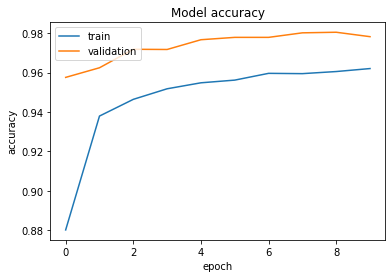

In [20]:
plt_metric(metric='accuracy', title='Model accuracy')

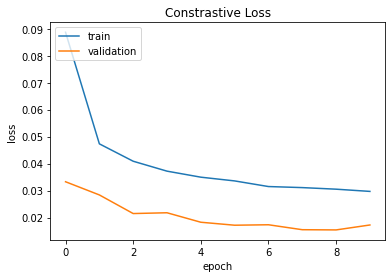

In [21]:
plt_metric(metric='loss', title='Constrastive Loss')

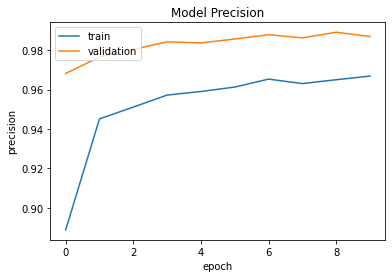

In [22]:
plt_metric(metric='precision', title='Model Precision')

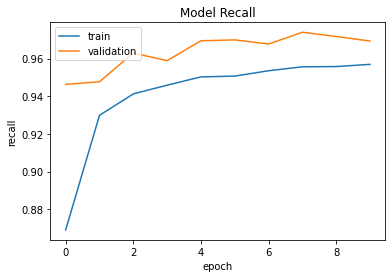

In [23]:
plt_metric(metric='recall', title='Model Recall')

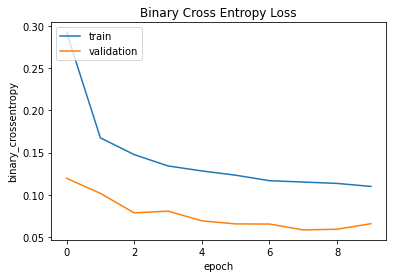

In [24]:
plt_metric(metric='binary_crossentropy', title='Binary Cross Entropy Loss')

Evaluate the model

In [25]:
results = siamese.evaluate([x_test_1, x_test_2], labels_test)
print("test loss, test acc:", results)

625/625 [==============================] - 3s 4ms/step - loss: 0.0169 - accuracy: 0.9783 - precision: 0.9877 - recall: 0.9686 - binary_crossentropy: 0.0626
test loss, test acc: [0.0169061366468668, 0.9782500267028809, 0.9876618981361389, 0.9685999751091003, 0.06261584162712097]


In [26]:
predictions = siamese.predict([x_test_1, x_test_2])

ROC curve

In [27]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(labels_test, predictions)

AUC

In [28]:
auc_keras = auc(fpr_keras, tpr_keras)

**Plot AUC**

 As a rule of thumb, an AUC above 0.85 means high classification accuracy, one between 0.75 and 0.85 moderate accuracy, and one less than 0.75 low accuracy (D' Agostino, Rodgers, & Mauck, 2018).

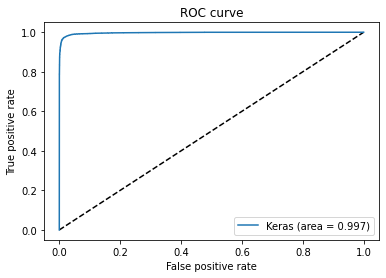

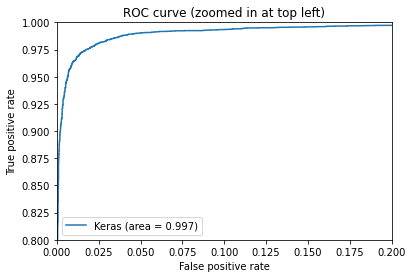

In [29]:

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

Visualize the predictions

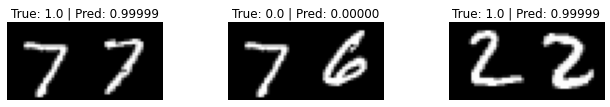

In [30]:
visualize(
    pairs_test, labels_test, to_show=3, predictions=predictions, test=True
)